In [56]:
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
import urllib
import requests
import json
import pandas as pd
from datetime import datetime,timedelta

yester = datetime.today() - timedelta(380)
yseter =  yester.strftime("%Y%m%d")
now_today = datetime.today() - timedelta(0)
now_today = now_today.strftime("%Y%m%d") 
print(yseter)
print(now_today)
my_api_key = 'input_your_api_key'

url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'
queryParams = '?' + \
'ServiceKey=' + '{}'.format(my_api_key) + \
'&pageNo='+ '1' + \
'&numOfRows='+ '999' + \
'&startCreateDt={}&endCreateDt={}'.format(yseter,now_today)


20191231
20210114


In [79]:
import xmltodict


result = requests.get(url + queryParams)
# print(result)
result = result.content 
jsonString = json.dumps(xmltodict.parse(result), indent = 4)
jsonString = jsonString.replace('resultCode', '결과코드').replace('resultMsg', '결과메세지').replace('numOfRows', '한 페이지 결과 수').replace('pageNo', '페이지 수').replace('totalCount', '전체 결과 수').replace('seq', '게시글번호(감염현황 고유값)').replace('stateDt', '기준일').replace('stateTime', '기준시간').replace('decideCnt', '누적 확진자 수').replace('clearCnt', '격리해제 수').replace('examCnt', '검사진행 수').replace('deathCnt', '누적 사망자 수').replace('careCnt', '치료중 환자 수').replace('resutlNegCnt', '결과 음성 수').replace('accExamCnt', '누적 검사 수').replace('accExamCompCnt', '누적 검사 완료 수').replace('accDefRate', '누적 확진률').replace('createDt', '등록일시분초').replace('updateDt', '수정일시분초')

js = json.loads(jsonString)
# print(js)
js_check_count = js["response"]['body']['items']['item'][0]['검사진행 수']
js = js["response"]['body']['items']['item']
all_data = pd.DataFrame(js)



In [80]:
select_data = all_data[['기준일','누적 사망자 수','누적 검사 수', '누적 확진자 수']]
# nan 값을 0으로 치환
select_data = select_data.fillna(0)
select_data.sort_values(by = '기준일', inplace = True, ascending = True)
select_data = select_data.reset_index(drop = True)
select_data

,기준일,누적 사망자 수,누적 검사 수,누적 확진자 수
0,20200101,0,0,0
1,20200202,2,0,2
2,20200203,0,0,15
3,20200204,0,0,0
4,20200205,0,0,19
...,...,...,...,...
379,20210110,1125,4723463,68663
380,20210111,1140,4751685,69114
381,20210112,1165,4814085,69650
382,20210113,1185,4872312,70204


In [107]:
select_data['누적 확진자 수'] = pd.to_numeric(select_data['누적 확진자 수'])
select_data['기준일'] = pd.to_datetime(select_data['기준일'])

# groupby를 사용하여 집계를 할 때 기준 연산을 설정.. 
f = {'누적 확진자 수':'min','누적 검사 수':'max','누적 사망자 수':'max'}
# 기준일을 기준으로 집계
data1 = select_data.groupby('기준일').agg(f)
# 기준일을 기준으로 정렬
data1.sort_values(by = '기준일', inplace=True, ascending = True)
pdata = data1.reset_index(drop = False)
pdata.columns = ['기준일', '누적 확진자 수', '누적 검사 수', '누적 사망자 수']
pdata

,기준일,누적 확진자 수,누적 검사 수,누적 사망자 수
0,2020-01-01,0,0,0
1,2020-02-02,2,0,2
2,2020-02-03,15,0,0
3,2020-02-04,0,0,0
4,2020-02-05,18,0,0
...,...,...,...,...
344,2021-01-10,68663,4723463,1125
345,2021-01-11,69114,4751685,1140
346,2021-01-12,69650,4814085,1165
347,2021-01-13,70204,4872312,1185


In [108]:
# 코로나 데이터가 일일 한번 저장되나, 정보의 변경으로 인한 업데이트 등이 일어날수 있다.
# 그래서 정보의 순서를 알지 못하기 때문에 데이터를 비교하여 큰수에서 작은 수를 빼는 함수를 정의했다.

In [109]:
def compare_sub(a,b):
    if a > b :
        c = a-b
        return c
    else :
        c = b-a
        return c

In [110]:
daily_crn_cnt = []
daily_check_cnt = []
for row in range(0,len(pdata['누적 확진자 수'])-1):
    daily_crn_cnt.append(compare_sub(int(pdata.loc[row+1][1]), int(pdata.loc[row][1])))
    # print(pdata['기준일'][row],',',int(pdata.loc[row+1][1]) ,'-', int(pdata.loc[row][1]) ,'=', compare_sub(int(pdata.loc[row+1][1]), int(pdata.loc[row][1])))
    daily_check_cnt.append(compare_sub(int(pdata.loc[row+1][2]),int(pdata.loc[row][2])))
    # print(pdata['기준일'][row],',',int(pdata.loc[row+1][2]),'-',int(pdata.loc[row][2]), '=', compare_sub(int(pdata.loc[row+1][2]),int(pdata.loc[row][2])))
pdata = pdata.drop(1)
pdata['일일 확진자 수'] = daily_crn_cnt
pdata['일일 검사 수'] = daily_check_cnt
pdata['일일 검사 수'] = pd.to_numeric(pdata["일일 검사 수"])
pdata['누적 사망자 수'] = pd.to_numeric(pdata['누적 사망자 수'])

In [102]:
## 출력하기
## pandas 시리즈 데이터를 numeric 으로 변경

Index(['기준일', '누적 확진자 수', '누적 검사 수', '누적 사망자 수', '일일 확진자 수', '일일 검사 수'], dtype='object')


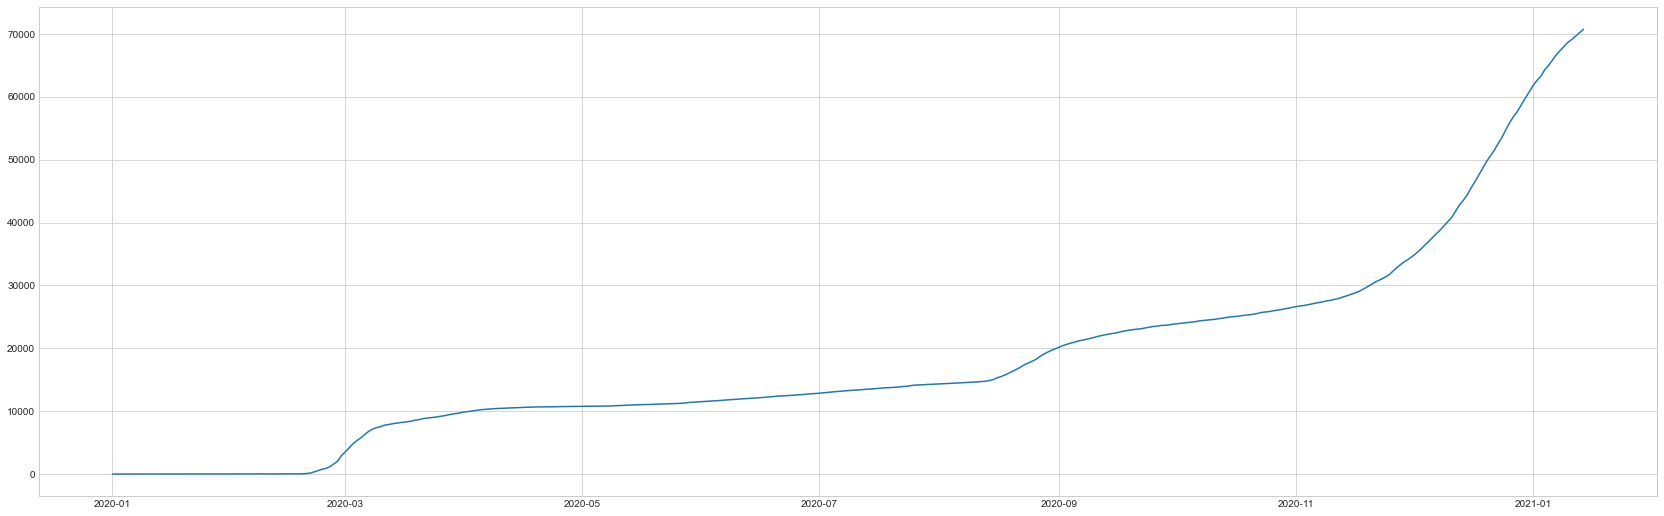

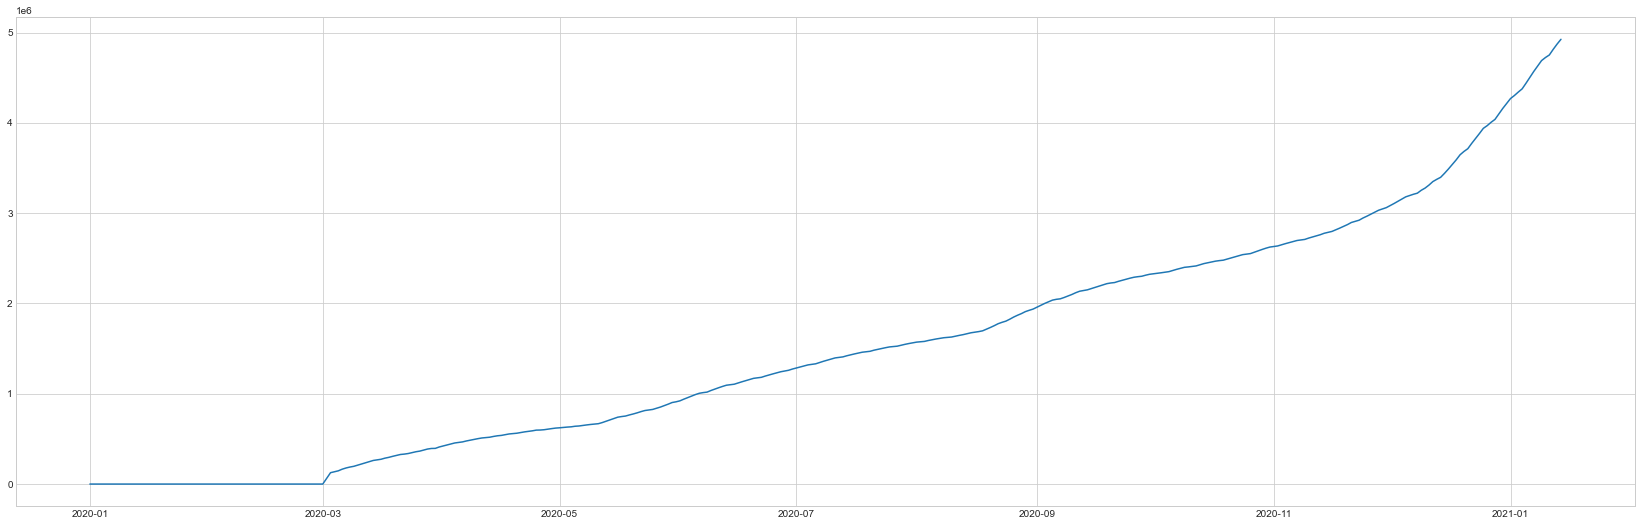

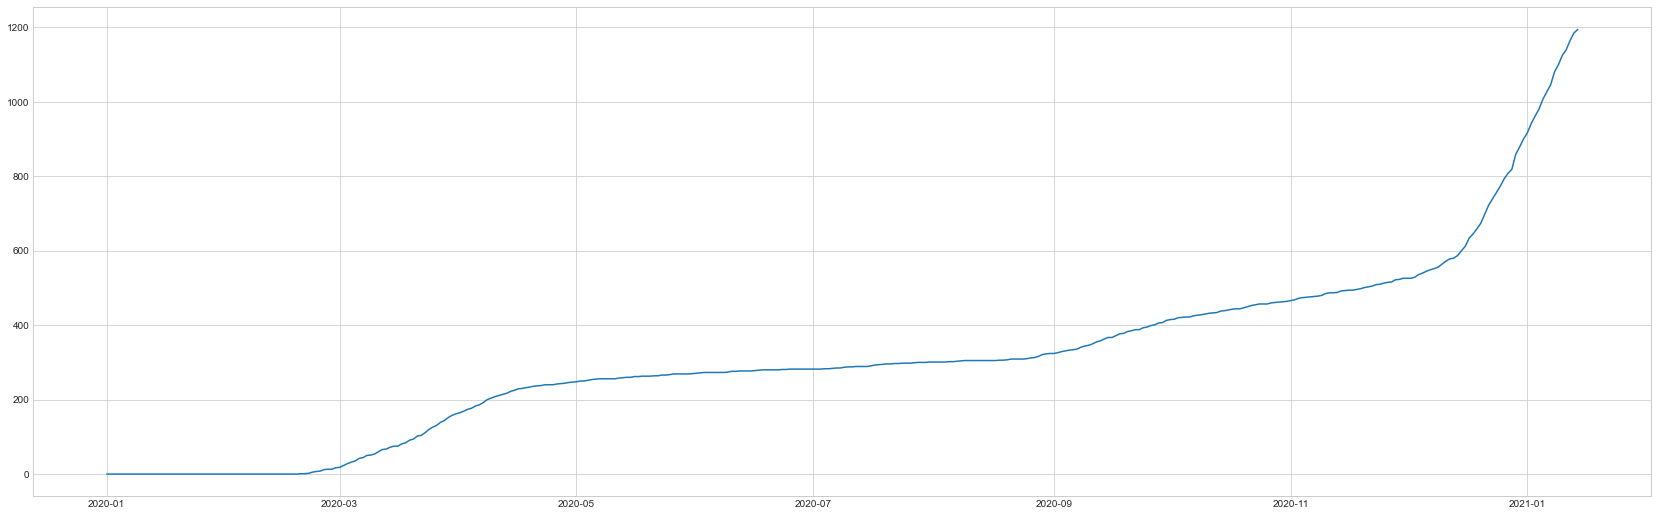

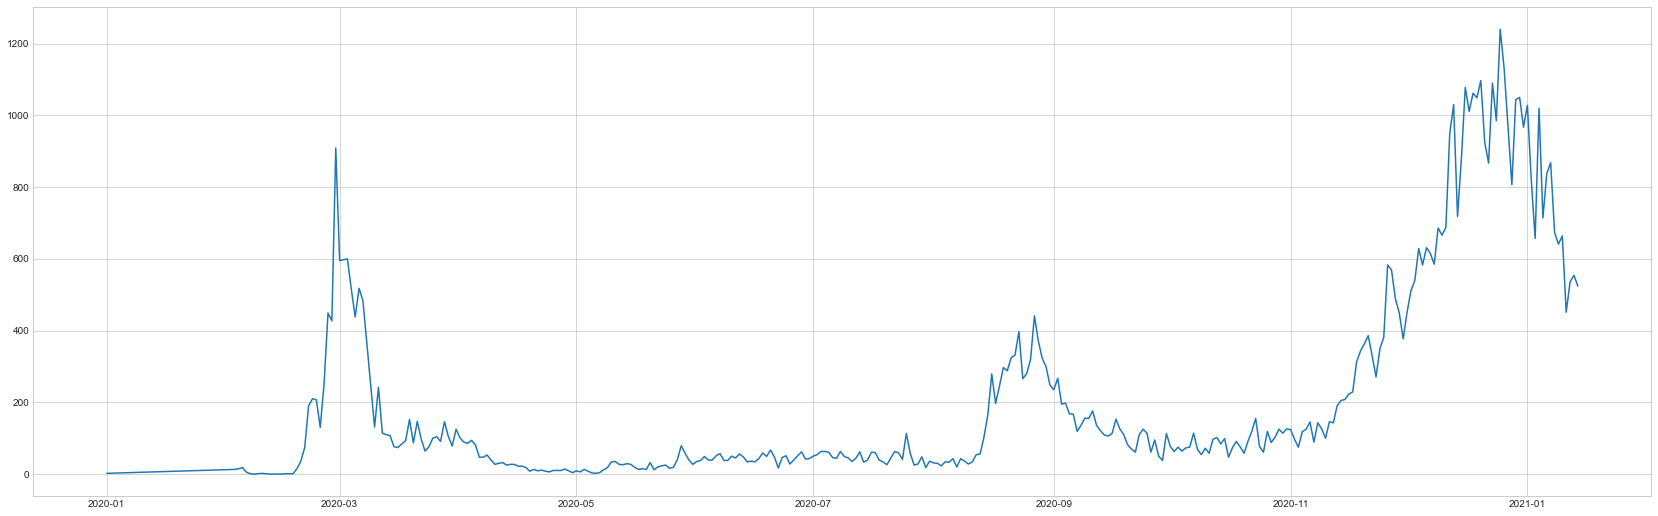

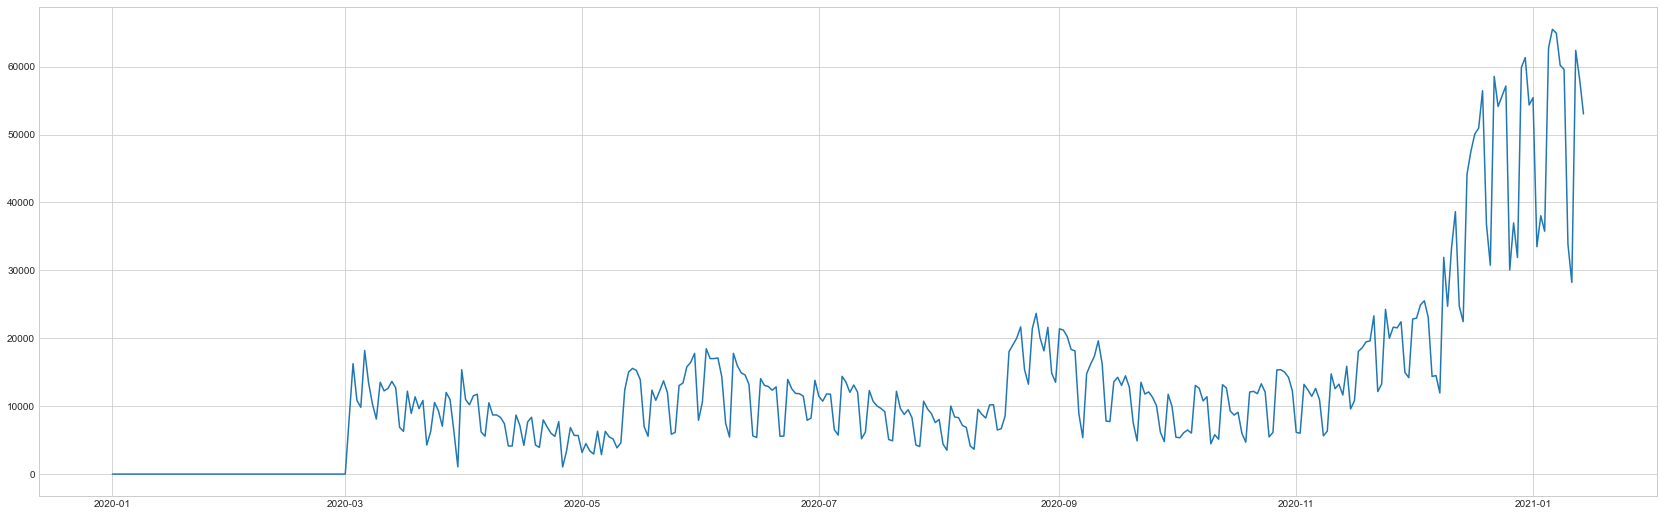

In [113]:
import matplotlib.pyplot as plt
import numpy as np

## 3월 초에 집계가 시작되어 이전 검사수를 모두 더한 데이터가 api상에 저장되있어 
## 그래프 표출시 오해의 소지가 있기 때문에 제거.
print(pdata.keys())
pdata = pdata[pdata["일일 검사 수"] <100000]
for a in pdata.keys():
    if a != '기준일':
        plt.style.use('seaborn-whitegrid')
        plt.figure(figsize=(29,9))
        plt.plot(pdata['기준일'],pdata[a])
        plt.show()



In [ ]:
pdata.to_csv("save_corona_data.csv")